## Antiguo proyecto de Redes Neuronales Recurrentes usando audios .wav, obteniendo su MFCC, aplicandolos a una RNN y validandolo con k fold cross validation

#### Librerias

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import IPython.display as ipd
import librosa
import librosa.display
import os
import soundfile as sf
import json
import random
from sklearn import preprocessing
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import numpy as np

from keras import Sequential
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import Activation
from keras.layers import Embedding
from keras.layers import RepeatVector
from keras.layers import TimeDistributed

import datetime
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from keras.callbacks import EarlyStopping
random.seed(0)

#### Funciones a usar

In [2]:
#Obtiene el path con el nombre de todos los archivos de un directorio.
def get_files_from_path(directory):
    path_files = []
    dir_list = os.listdir(directory)
    for path in dir_list:
        path_files.append(directory+"\\"+path)
    return path_files


#Extrae los paths que cumplan con un codigo
def extract_paths_for_emotions_keys(emotions_code, files_path, get_code):
    paths = []
    emotions_set = set(emotions_code)
    for code_file in files_path:
        if (get_code(code_file) in emotions_set):
            paths.append(code_file)
    return paths


#Obtiene el codigo en el nombre del archivo para el dataset CREMA-D
def get_code_crema_d(path):
    return path[119:122]


#Obtiene el codigo en el nombre del archivo para el dataset SAVEE
def get_code_savee(path):
    return path[108]


#Esta función abre el archivo .wav y obtiene el mfcc escalado en un vector de 40 elementos.
def features_extractor(file_name):
    audio, sample_rate = librosa.load(file_name, res_type='kaiser_fast')
    mfccs_features = librosa.feature.mfcc(y=audio,sr=sample_rate,n_mfcc=40)
    mfccs_scaled_features = np.mean(mfccs_features.T, axis=0)
    return mfccs_scaled_features


#Esta función permite guardar los MFCC en 'features', el código en 'code' y su dirección en 'path' en un archivo json. 
def save_elements_in_json(examples_saved, name):
    json_files = []
    json_file = {}
    index = 0
    for file in examples_saved:
        json_file = {"id": index, "features":[str(elem) for elem in file[0]] ,"code":file[1], "path":file[2]}
        json_files.append(json_file)
        index += 1
    json_object = json.dumps(json_files)
    with open(f"{name}.json", "w") as outfile:
        outfile.write(json_object)
   

#La función permite cargar datos del MFCC y código desde un archivo json.
def load_elements_from_json(name):
    f = open(f'{name}.json')
    data = json.load(f)
    examples = []
    for element in data:
        examples.append(([float(feature) for feature in (element["features"])], element["code"]))
    return examples


#La función nos permite devolver una lista de MFCC obtenidos de una lista de paths. 
#El MFCC tiene un límite que no le permite cargar archivos menor o igual a 44 kb.
#Con el diccionario obtenemos el total de audios recuperados por emoción.
def get_features(paths,get_code, files_filters = dict()):
    examples = []
    for path in paths:
        code = get_code(path)
        file_stats = os.stat(path)
        if (file_stats.st_size > 44):
            feature = features_extractor(path)
            files_filters[code]+= 1
            examples.append((feature,code))
    print(f"Se obtuvo el MFCC de unos {len(paths)} sobre {sum(files_filters[files] for files in files_filters)} audios.")
    return examples


#Selecciona n ejemplos que necesitemos y los mezcla.
def select_elements(examples, code, quantity, new_code):
    random.shuffle(examples)
    elements = []
    counter = 1
    for example in examples:
        if (counter > quantity):
            break
        if code == example[1]:
            elements.append((example[0],new_code))
            counter = counter + 1
    return elements

Los siguientes bloques obtienen los paths y filtra las emociones que necesitemos en cada dataset (CREMA-D y SAVEE).

#### Funciones para obtener los datos 

In [3]:
#Obtiene todos los datos de CREMA-D y SAVEE para un  
def get_datas():
    files_path = get_files_from_path(f"{os.getcwd()}\\..\\..\\Datasets\\AudioWav")
    emotions_code = ["NEU", "FEA","ANG"]
    datas_files = extract_paths_for_emotions_keys(emotions_code, files_path, get_code_crema_d)
    files_path_s = get_files_from_path(f"{os.getcwd()}\\..\\..\\Datasets\\ALL")
    emotions_code_s = ["a", "f","n"]
    datas_files_s = extract_paths_for_emotions_keys(emotions_code_s, files_path_s, get_code_savee) 
    examples = []
    files_filters = dict()
    files_filters["NEU"] = 0
    files_filters["FEA"] = 0
    files_filters["ANG"] = 0
    files_filters["a"] = 0
    files_filters["f"] = 0
    files_filters["n"] = 0
    examples = get_features(datas_files, get_code_crema_d, files_filters)
    examples_s = get_features(datas_files_s, get_code_savee, files_filters)
    return examples + examples_s

#Obtiene los datos de entrada para la red neuronal x: mfcc normalizados, y: labeles categorizados
def get_entries():
    all_examples = get_datas()
    entries = []
    for example in all_examples:
        entries.append((example[0], example[1]))
    '''
    datas = select_elements(entries, 'NEU', 896,"without_stress")
    datas += select_elements(entries, 'ANG', 550, "stress")
    datas += select_elements(entries, 'FEA', 550, "stress")
    datas += select_elements(entries, 'a', 60, "stress")
    datas += select_elements(entries, 'f', 60, "stress")
    datas += select_elements(entries, 'n', 120, "without_stress")
    '''
    '''
    datas = select_elements(entries, 'NEU', 1087,"without_stress")
    datas += select_elements(entries, 'ANG', 1271, "stress")
    datas += select_elements(entries, 'FEA', 1270, "stress")
    datas += select_elements(entries, 'a', 60, "stress")
    datas += select_elements(entries, 'f', 60, "stress")
    datas += select_elements(entries, 'n', 120, "without_stress")  
    '''
    datas = select_elements(entries, 'NEU', 1086,"without_stress")
    datas += select_elements(entries, 'ANG', 543, "stress")
    datas += select_elements(entries, 'FEA', 543, "stress")
    datas += select_elements(entries, 'a', 60, "stress")
    datas += select_elements(entries, 'f', 60, "stress")
    datas += select_elements(entries, 'n', 120, "without_stress")
    random.shuffle(datas)
    X = []
    y = []
    for data in datas:
        X.append(data[0])
        y.append(data[1])
    labelencoder=preprocessing.LabelEncoder()
    y = to_categorical(labelencoder.fit_transform(y))
    return X, y

#Obtiene los datos divididos de entrenamiento y tests
def obtain_datas_train_and_test(percentage):
    X, y = get_entries()
    X_test, X_train, y_test, y_train = train_test_split(X, y, test_size =percentage,random_state=0)
    y = np.array(y)
    X_train = np.array(X_train)
    X_test = np.array(X_test)
    y_train = np.array(y_train)
    y_test = np.array(y_test)
    return X_train, X_test, y_train, y_test

In [10]:
X_train, X_test, y_train, y_test = obtain_datas_train_and_test(0.8)
num_labels = y_train.shape[1] + y_test.shape[1]
dim_entrada = (X_train.shape[1],1)

Se obtuvo el MFCC de unos 3629 sobre 3628 audios.
Se obtuvo el MFCC de unos 240 sobre 3868 audios.


In [11]:
X_train.shape

(1930, 40)

In [12]:
print(X_train[0], X_train[0].shape)
print(y_train[0], y_train[0].shape)

[-3.0196533e+02  1.2661277e+02 -1.7413252e+01  3.8431168e+01
 -1.8980343e+01  8.9880533e+00 -1.4495820e+01  2.4344163e+00
 -2.5121801e+00 -6.2962627e+00  4.9583282e+00 -9.8670769e+00
  3.8368664e+00 -9.0873127e+00  6.8555489e-02 -7.7005901e+00
 -6.4836807e+00 -6.3730007e-01 -5.6727729e+00  3.8049169e+00
 -2.7038636e+00  2.1113586e+00 -1.9371136e+00 -1.9170235e+00
 -3.3414203e-01  9.5338237e-01  6.0309019e+00  4.1676326e+00
  3.9714208e+00  2.3788235e-01  1.8979012e+00  2.6911440e+00
  5.9430146e+00  1.6919498e+00 -2.1927528e+00 -1.5151044e+00
 -3.3090804e+00  1.8088093e-01  3.9706416e-02  1.8872486e+00] (40,)
[1. 0.] (2,)


In [17]:
'''
def new_RNN():
    model = Sequential()
    model.add(LSTM(units=50,input_shape= dim_entrada, return_sequences=False))
#    model.add(LSTM(units=16,input_shape= dim_entrada, return_sequences=True))
#    model.add(LSTM(units=4,input_shape= dim_entrada, return_sequences=False))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))
    model.add(Dense(2,activation='softmax'))
    model.compile(loss='categorical_crossentropy', metrics=['accuracy'],optimizer='adam')
    return model
    
    def new_RNN():
    model = Sequential()
    model.add(LSTM(units=50, input_shape = dim_entrada))
    model.add(Dense(2, activation='sigmoid'))
    model.compile(loss='categorical_crossentropy', metrics=['accuracy'],optimizer='adam')
    return model
'''
def new_RNN():
    model = Sequential()
    model.add(LSTM(units=50, input_shape = dim_entrada, return_sequences=True))
    model.add(LSTM(units=40, input_shape = dim_entrada, return_sequences=False))
    model.add(Dropout(0.5))
    model.add(Dense(8, activation='sigmoid'))
    model.add(Dropout(0.5))
    model.add(Dense(2, activation='sigmoid'))
    model.compile(loss='categorical_crossentropy', metrics=['accuracy'],optimizer='adam')
    return model

In [18]:
model = new_RNN()
model.summary()

Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_34 (LSTM)              (None, 40, 50)            10400     
                                                                 
 lstm_35 (LSTM)              (None, 40)                14560     
                                                                 
 dropout_34 (Dropout)        (None, 40)                0         
                                                                 
 dense_34 (Dense)            (None, 8)                 328       
                                                                 
 dropout_35 (Dropout)        (None, 8)                 0         
                                                                 
 dense_35 (Dense)            (None, 2)                 18        
                                                                 
Total params: 25,306
Trainable params: 25,306
Non-tra

In [20]:
k_fold = KFold(5)
fold = 0
y_tests = []
predictions = []
scores = []
X = np.concatenate((X_train, X_test))
y = np.concatenate((y_train, y_test))
for train, test in k_fold.split(X):
    fold = fold + 1
    print(f"Fold #{fold}")
    X_train = X[train]
    X_test = X[test]
    y_train = y[train]
    y_test = y[test]
    print(f"Train - X:{X_train.shape} y:{y_train.shape}")
    print(f"Test - X:{X_test.shape} y:{y_test.shape}")
    
    num_labels = y.shape[1]
    dim_entrada = (X_train.shape[1],1)

    #model = new_RNN()
    model = new_RNN()
    callbacks = []
    '''
    callbacks = [
    EarlyStopping(
            monitor="val_loss",
            min_delta=1e-2,
            patience=20,
            verbose=1,
        )
    ]
    '''
    num_epochs = 100
    num_batch_size = 32
    start = datetime.datetime.now()
   
    results = model.fit(X_train, y_train, batch_size=num_batch_size,epochs=num_epochs, validation_data=(X_test, y_test),callbacks=callbacks)

    pred = model.predict(X_test)
    y_tests.append(y_test)
    pred=[([1,0] if i[0]>i[1] else [0,1]) for i in pred]
    predictions.append(pred)
    score = metrics.accuracy_score(pred, y_test)
    math = confusion_matrix([(1 if x[0]==1 else 0) for x in pred],[(1 if x[0]==1 else 0) for x in y_test], labels=[1,0])
    scores.append([score])
    print(f"Fold score (Accuracy score): {score}")
    print("Matriz de confusion")
    print("-------------------")
    print("---------| Verdadero | Falso |")
    print(f"Verdadero|  {math[0][0]}        {math[0][1]}")
    print(f"Falso    |  {math[1][0]}        {math[1][1]}")

y_tests = np.concatenate(y_tests)
predictions = np.concatenate(predictions)
score = metrics.accuracy_score(predictions, y_tests)
print("-----------------------")
print(f"Cross-validated score (Accuracy score): {score}")
print("-----------------------")
print("Resumen")
for result in scores:
    print(f"Fold score (Accuracy score): {result[0]}")
    
#https://github.com/jeffheaton/t81_558_deep_learning/blob/master/t81_558_class_05_2_kfold.ipynb
#https://www.youtube.com/watch?v=maiQf8ray_s

Fold #1
Train - X:(1929, 40) y:(1929, 2)
Test - X:(483, 40) y:(483, 2)
Epoch 1/100
61/61 [==============================] - 34s 315ms/step - loss: 0.7902 - accuracy: 0.4914 - val_loss: 0.6883 - val_accuracy: 0.5756
Epoch 2/100
61/61 [==============================] - 7s 118ms/step - loss: 0.6978 - accuracy: 0.5163 - val_loss: 0.6827 - val_accuracy: 0.5942
Epoch 3/100
61/61 [==============================] - 7s 114ms/step - loss: 0.6811 - accuracy: 0.5614 - val_loss: 0.6562 - val_accuracy: 0.6460
Epoch 4/100
61/61 [==============================] - 7s 122ms/step - loss: 0.6662 - accuracy: 0.6050 - val_loss: 0.6331 - val_accuracy: 0.6480
Epoch 5/100
61/61 [==============================] - 8s 123ms/step - loss: 0.6512 - accuracy: 0.6190 - val_loss: 0.6388 - val_accuracy: 0.6190
Epoch 6/100
61/61 [==============================] - 7s 119ms/step - loss: 0.6442 - accuracy: 0.6257 - val_loss: 0.6069 - val_accuracy: 0.6832
Epoch 7/100
61/61 [==============================] - 7s 121ms/step - l

61/61 [==============================] - 6s 103ms/step - loss: 0.4740 - accuracy: 0.7688 - val_loss: 0.4934 - val_accuracy: 0.7495
Epoch 58/100
61/61 [==============================] - 6s 104ms/step - loss: 0.4823 - accuracy: 0.7605 - val_loss: 0.5263 - val_accuracy: 0.7329
Epoch 59/100
61/61 [==============================] - 6s 103ms/step - loss: 0.4863 - accuracy: 0.7662 - val_loss: 0.5108 - val_accuracy: 0.7371
Epoch 60/100
61/61 [==============================] - 6s 104ms/step - loss: 0.4820 - accuracy: 0.7652 - val_loss: 0.5159 - val_accuracy: 0.7557
Epoch 61/100
61/61 [==============================] - 6s 104ms/step - loss: 0.5165 - accuracy: 0.7522 - val_loss: 0.4967 - val_accuracy: 0.7433
Epoch 62/100
61/61 [==============================] - 6s 105ms/step - loss: 0.4845 - accuracy: 0.7636 - val_loss: 0.5093 - val_accuracy: 0.7350
Epoch 63/100
61/61 [==============================] - 6s 104ms/step - loss: 0.4918 - accuracy: 0.7698 - val_loss: 0.5381 - val_accuracy: 0.7371
Epoch

Epoch 12/100
61/61 [==============================] - 6s 101ms/step - loss: 0.5638 - accuracy: 0.6952 - val_loss: 0.5678 - val_accuracy: 0.6957
Epoch 13/100
61/61 [==============================] - 6s 101ms/step - loss: 0.5628 - accuracy: 0.6998 - val_loss: 0.5591 - val_accuracy: 0.6977
Epoch 14/100
61/61 [==============================] - 6s 101ms/step - loss: 0.5717 - accuracy: 0.7009 - val_loss: 0.6106 - val_accuracy: 0.6253
Epoch 15/100
61/61 [==============================] - 6s 102ms/step - loss: 0.5793 - accuracy: 0.6884 - val_loss: 0.5464 - val_accuracy: 0.6957
Epoch 16/100
61/61 [==============================] - 6s 101ms/step - loss: 0.5566 - accuracy: 0.7097 - val_loss: 0.5443 - val_accuracy: 0.7184
Epoch 17/100
61/61 [==============================] - 6s 101ms/step - loss: 0.5542 - accuracy: 0.7232 - val_loss: 0.5403 - val_accuracy: 0.7164
Epoch 18/100
61/61 [==============================] - 6s 101ms/step - loss: 0.5528 - accuracy: 0.7133 - val_loss: 0.5469 - val_accuracy:

61/61 [==============================] - 6s 97ms/step - loss: 0.4347 - accuracy: 0.7786 - val_loss: 0.5395 - val_accuracy: 0.7143
Epoch 70/100
61/61 [==============================] - 6s 96ms/step - loss: 0.4256 - accuracy: 0.7849 - val_loss: 0.4849 - val_accuracy: 0.7681
Epoch 71/100
61/61 [==============================] - 6s 95ms/step - loss: 0.4432 - accuracy: 0.7703 - val_loss: 0.4777 - val_accuracy: 0.7598
Epoch 72/100
61/61 [==============================] - 6s 96ms/step - loss: 0.4357 - accuracy: 0.7745 - val_loss: 0.4848 - val_accuracy: 0.7619
Epoch 73/100
61/61 [==============================] - 6s 96ms/step - loss: 0.4242 - accuracy: 0.7895 - val_loss: 0.5567 - val_accuracy: 0.6998
Epoch 74/100
61/61 [==============================] - 6s 95ms/step - loss: 0.4608 - accuracy: 0.7621 - val_loss: 0.4860 - val_accuracy: 0.7536
Epoch 75/100
61/61 [==============================] - 6s 96ms/step - loss: 0.4299 - accuracy: 0.7797 - val_loss: 0.4790 - val_accuracy: 0.7660
Epoch 76/100

61/61 [==============================] - 3s 54ms/step - loss: 0.5500 - accuracy: 0.7036 - val_loss: 0.5023 - val_accuracy: 0.7635
Epoch 25/100
61/61 [==============================] - 3s 51ms/step - loss: 0.5325 - accuracy: 0.7311 - val_loss: 0.5077 - val_accuracy: 0.7448
Epoch 26/100
61/61 [==============================] - 3s 49ms/step - loss: 0.5297 - accuracy: 0.7301 - val_loss: 0.5157 - val_accuracy: 0.7552
Epoch 27/100
61/61 [==============================] - 3s 52ms/step - loss: 0.5466 - accuracy: 0.7026 - val_loss: 0.5220 - val_accuracy: 0.7344
Epoch 28/100
61/61 [==============================] - 4s 65ms/step - loss: 0.5408 - accuracy: 0.7124 - val_loss: 0.5172 - val_accuracy: 0.7469
Epoch 29/100
61/61 [==============================] - 3s 52ms/step - loss: 0.5390 - accuracy: 0.7176 - val_loss: 0.5244 - val_accuracy: 0.7635
Epoch 30/100
61/61 [==============================] - 3s 52ms/step - loss: 0.5389 - accuracy: 0.7192 - val_loss: 0.5038 - val_accuracy: 0.7780
Epoch 31/100

61/61 [==============================] - 3s 56ms/step - loss: 0.4228 - accuracy: 0.8088 - val_loss: 0.4663 - val_accuracy: 0.8050
Epoch 82/100
61/61 [==============================] - 3s 53ms/step - loss: 0.4141 - accuracy: 0.8155 - val_loss: 0.5061 - val_accuracy: 0.7739
Epoch 83/100
61/61 [==============================] - 4s 58ms/step - loss: 0.4064 - accuracy: 0.8135 - val_loss: 0.5128 - val_accuracy: 0.7822
Epoch 84/100
61/61 [==============================] - 3s 57ms/step - loss: 0.4016 - accuracy: 0.8202 - val_loss: 0.4784 - val_accuracy: 0.8029
Epoch 85/100
61/61 [==============================] - 3s 52ms/step - loss: 0.4210 - accuracy: 0.8114 - val_loss: 0.5315 - val_accuracy: 0.7718
Epoch 86/100
61/61 [==============================] - 3s 53ms/step - loss: 0.4177 - accuracy: 0.8181 - val_loss: 0.4895 - val_accuracy: 0.8050
Epoch 87/100
61/61 [==============================] - 3s 56ms/step - loss: 0.3972 - accuracy: 0.8306 - val_loss: 0.4969 - val_accuracy: 0.7905
Epoch 88/100

61/61 [==============================] - 4s 62ms/step - loss: 0.5244 - accuracy: 0.7192 - val_loss: 0.5067 - val_accuracy: 0.7033
Epoch 37/100
61/61 [==============================] - 4s 66ms/step - loss: 0.5183 - accuracy: 0.7155 - val_loss: 0.4376 - val_accuracy: 0.7884
Epoch 38/100
61/61 [==============================] - 5s 84ms/step - loss: 0.5041 - accuracy: 0.7326 - val_loss: 0.4298 - val_accuracy: 0.8029
Epoch 39/100
61/61 [==============================] - 4s 61ms/step - loss: 0.4923 - accuracy: 0.7451 - val_loss: 0.4239 - val_accuracy: 0.7988
Epoch 40/100
61/61 [==============================] - 5s 81ms/step - loss: 0.4918 - accuracy: 0.7461 - val_loss: 0.4227 - val_accuracy: 0.8050
Epoch 41/100
61/61 [==============================] - 5s 87ms/step - loss: 0.4931 - accuracy: 0.7311 - val_loss: 0.4663 - val_accuracy: 0.7863
Epoch 42/100
61/61 [==============================] - 4s 71ms/step - loss: 0.4900 - accuracy: 0.7534 - val_loss: 0.4114 - val_accuracy: 0.8029
Epoch 43/100

61/61 [==============================] - 4s 59ms/step - loss: 0.3992 - accuracy: 0.8052 - val_loss: 0.4159 - val_accuracy: 0.7946
Epoch 94/100
61/61 [==============================] - 4s 60ms/step - loss: 0.3988 - accuracy: 0.7995 - val_loss: 0.4071 - val_accuracy: 0.7925
Epoch 95/100
61/61 [==============================] - 3s 57ms/step - loss: 0.3959 - accuracy: 0.8026 - val_loss: 0.4180 - val_accuracy: 0.8029
Epoch 96/100
61/61 [==============================] - 3s 57ms/step - loss: 0.4455 - accuracy: 0.7627 - val_loss: 0.4556 - val_accuracy: 0.7822
Epoch 97/100
61/61 [==============================] - 4s 64ms/step - loss: 0.4463 - accuracy: 0.7648 - val_loss: 0.4155 - val_accuracy: 0.8071
Epoch 98/100
61/61 [==============================] - 4s 70ms/step - loss: 0.4446 - accuracy: 0.7637 - val_loss: 0.4267 - val_accuracy: 0.7759
Epoch 99/100
61/61 [==============================] - 4s 69ms/step - loss: 0.4115 - accuracy: 0.7855 - val_loss: 0.4979 - val_accuracy: 0.7801
Epoch 100/10

61/61 [==============================] - 4s 67ms/step - loss: 0.4742 - accuracy: 0.7585 - val_loss: 0.4855 - val_accuracy: 0.7407
Epoch 49/100
61/61 [==============================] - 4s 59ms/step - loss: 0.4737 - accuracy: 0.7591 - val_loss: 0.4951 - val_accuracy: 0.7448
Epoch 50/100
61/61 [==============================] - 4s 63ms/step - loss: 0.4622 - accuracy: 0.7782 - val_loss: 0.4678 - val_accuracy: 0.7656
Epoch 51/100
61/61 [==============================] - 5s 82ms/step - loss: 0.4705 - accuracy: 0.7611 - val_loss: 0.5059 - val_accuracy: 0.7116
Epoch 52/100
61/61 [==============================] - 5s 82ms/step - loss: 0.4643 - accuracy: 0.7674 - val_loss: 0.4618 - val_accuracy: 0.7510
Epoch 53/100
61/61 [==============================] - 5s 85ms/step - loss: 0.4586 - accuracy: 0.7782 - val_loss: 0.4791 - val_accuracy: 0.7303
Epoch 54/100
61/61 [==============================] - 4s 66ms/step - loss: 0.4479 - accuracy: 0.7881 - val_loss: 0.4881 - val_accuracy: 0.7510
Epoch 55/100

In [ ]:
def new_RNN():
    model = Sequential()
    model.add(LSTM(units=50,input_shape= dim_entrada, return_sequences=False))
#    model.add(LSTM(units=16,input_shape= dim_entrada, return_sequences=True))
#    model.add(LSTM(units=4,input_shape= dim_entrada, return_sequences=False))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))
    model.add(Dense(2,activation='softmax'))
    model.compile(loss='categorical_crossentropy', metrics=['accuracy'],optimizer='adam')
    return model

'''
Cross-validated score (Accuracy score): 0.8200663349917081
-----------------------
Resumen
Fold score (Accuracy score): 0.8281573498964804
Fold score (Accuracy score): 0.8426501035196687
Fold score (Accuracy score): 0.8008298755186722
Fold score (Accuracy score): 0.8174273858921162
Fold score (Accuracy score): 0.8112033195020747
'''

In [66]:
#50 0.77
model = new_RNN()
model.summary()
#https://keras.io/api/callbacks/early_stopping/
callbacks = []

callbacks = [
    EarlyStopping(
        monitor="val_accuracy",
        min_delta=0.01, #si un epochs mejora como un min_delta respecto a la anterior, no contara como mejora
        patience=70,#numero de epochs sin mejoras que se tendra paciencia
        verbose=1,#mostrar informacion extra, 0 no mostrar
     )
]

num_epochs = 80
num_batch_size = 32
start = datetime.datetime.now()
   
results = model.fit(X_train, y_train, batch_size=num_batch_size,epochs=num_epochs, validation_data=(X_test, y_test),callbacks=callbacks)
duration = datetime.datetime.now() - start
test_accuracy = model.evaluate(X_test, y_test, verbose=0)
print(f"val_loss: {test_accuracy[0]}", f"val_accuracy: {test_accuracy[1]}")
y_values = model.predict(X_test)
y_prediction=[([1,0] if i[0]>i[1] else [0,1]) for i in y_values]
y_i = len(y_values)
i = 0
true_values = 0
while (i < y_i):
    true_values += (1 if (y_test[i][0] == y_prediction[i][0] or y_test[i][1] == y_prediction[i][1]) else 0)
    i = i + 1 
print(f"El algoritmo acerto {true_values} veces sobre los {y_i} casos.")

Model: "sequential_52"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_52 (LSTM)              (None, 50)                10400     
                                                                 
 dense_58 (Dense)            (None, 8)                 408       
                                                                 
 dropout_52 (Dropout)        (None, 8)                 0         
                                                                 
 dense_59 (Dense)            (None, 2)                 18        
                                                                 
Total params: 10,826
Trainable params: 10,826
Non-trainable params: 0
_________________________________________________________________
Epoch 1/80
61/61 [==============================] - 6s 57ms/step - loss: 0.8525 - accuracy: 0.4995 - val_loss: 0.6909 - val_accuracy: 0.5249
Epoch 2/80
61/61 [======================

61/61 [==============================] - 3s 44ms/step - loss: 0.5045 - accuracy: 0.7373 - val_loss: 0.4642 - val_accuracy: 0.7905
Epoch 53/80
61/61 [==============================] - 3s 43ms/step - loss: 0.4887 - accuracy: 0.7513 - val_loss: 0.4518 - val_accuracy: 0.7842
Epoch 54/80
61/61 [==============================] - 3s 42ms/step - loss: 0.5000 - accuracy: 0.7456 - val_loss: 0.4469 - val_accuracy: 0.7988
Epoch 55/80
61/61 [==============================] - 3s 43ms/step - loss: 0.4821 - accuracy: 0.7617 - val_loss: 0.4367 - val_accuracy: 0.8257
Epoch 56/80
61/61 [==============================] - 3s 42ms/step - loss: 0.4769 - accuracy: 0.7637 - val_loss: 0.4444 - val_accuracy: 0.7759
Epoch 57/80
61/61 [==============================] - 2s 41ms/step - loss: 0.4804 - accuracy: 0.7580 - val_loss: 0.4628 - val_accuracy: 0.7510
Epoch 58/80
61/61 [==============================] - 3s 42ms/step - loss: 0.4638 - accuracy: 0.7705 - val_loss: 0.4015 - val_accuracy: 0.8195
Epoch 59/80
61/61 

In [67]:
training_loss = results.history['loss']
test_loss = results.history['val_loss']
epochs_range = range(1, len(training_loss) + 1)

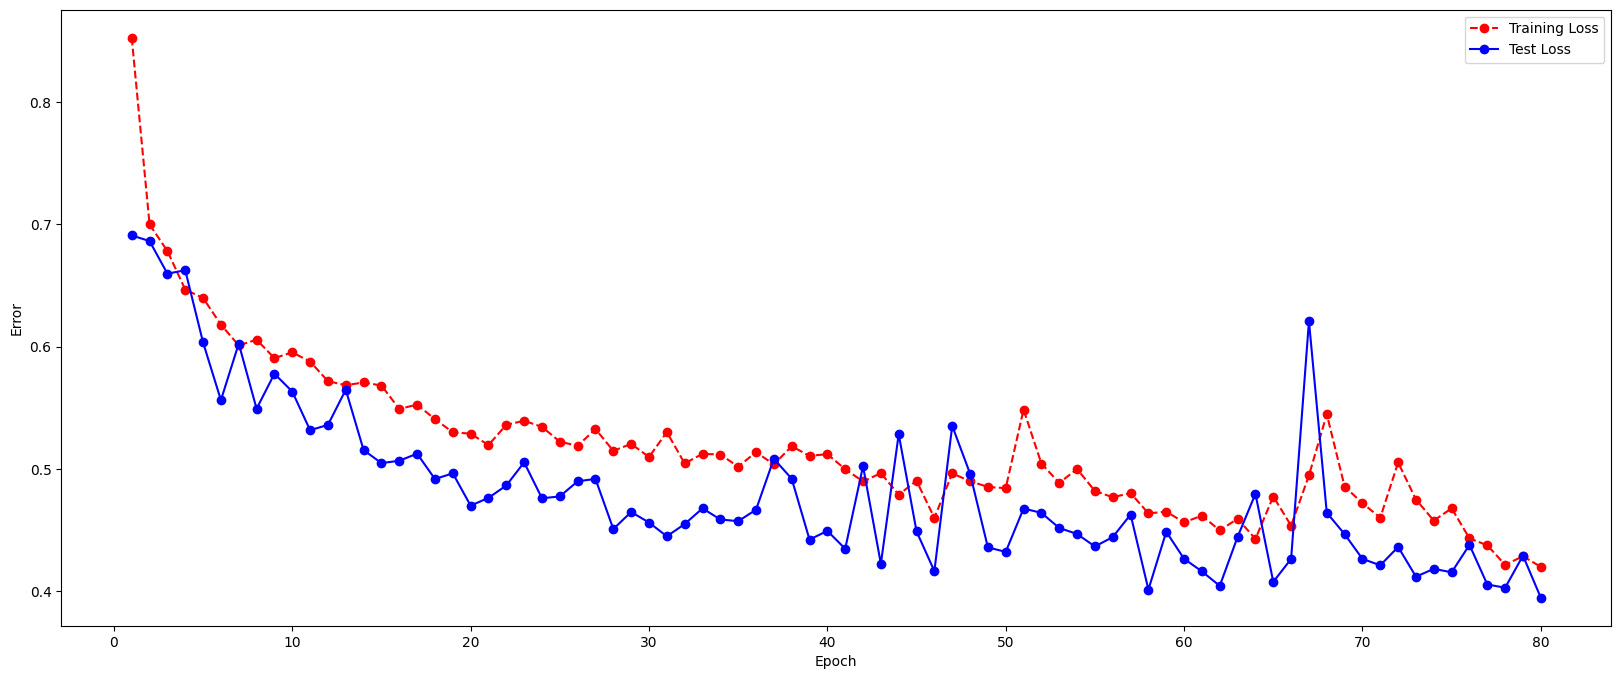

In [69]:
plt.plot(epochs_range, training_loss, 'r',marker="o",linestyle="--")
plt.plot(epochs_range, test_loss, 'b',marker="o",linestyle="-")
plt.legend(['Training Loss', 'Test Loss'])
plt.xlabel('Epoch')
plt.ylabel('Error')
plt.rcParams["figure.figsize"] = (20,8)
plt.show()

In [14]:
test_accuracy = model.evaluate(X_test, y_test, verbose=0)
print(f"val_loss: {test_accuracy[0]}", f"val_accuracy: {test_accuracy[1]}")

y_i = len(y_values)
i = 0
true_values = 0
while (i < y_i):
    true_values += (1 if (y_test[i][0] == y_prediction[i][0] or y_test[i][1] == y_prediction[i][1]) else 0)
    i = i + 1 
    
print(f"El algoritmo acerto {true_values} veces sobre los {y_i} casos.")

val_loss: 0.40328726172447205 val_accuracy: 0.8150064945220947


NameError: name 'y_values' is not defined

In [77]:
'''
val_loss: 0.42675861716270447 val_accuracy: 0.7767857313156128
val_loss: 0.44326552748680115 val_accuracy: 0.7611607313156128
val_loss: 0.4475260078907013 val_accuracy: 0.7566964030265808
'''

'\nval_loss: 0.42675861716270447 val_accuracy: 0.7767857313156128\nval_loss: 0.44326552748680115 val_accuracy: 0.7611607313156128\nval_loss: 0.4475260078907013 val_accuracy: 0.7566964030265808\n'

#### Crossvalidation

In [57]:
X = np.array(X)
y = np.array(y)
print(f"X:{X.shape} y:{y.shape}")

X:(2236, 40) y:(2236, 2)


In [69]:
from sklearn.model_selection import KFold
from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix


El bloque realizara el k fold cross validation dividiendolo en 5 folds, se uso los MSE.

In [28]:
# serialize model to JSON
model_json = model.to_json()
with open("model_5.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("model_5.h5")
print("Saved model to disk")

Saved model to disk
